In [2]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [3]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
from datetime import datetime, timedelta
print("Libraries imported correctly")

Libraries imported correctly


In [4]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb

In [5]:
ini_equity_default = 100
commision_default = 2/130000 + 12.5/130000 #0.000111538462, around 0.011..% of the equity

## Download data from SP500

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23345 entries, 1928-01-03 to 2020-12-08
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             23345 non-null  float64
 1   Market_daily_ret  23345 non-null  float64
dtypes: float64(2)
memory usage: 547.1 KB


,Close,Market_daily_ret
Date,,
2020-12-02,3669.010010,0.001791
2020-12-03,3666.719971,-0.000624
2020-12-04,3699.120117,0.008836
2020-12-07,3691.959961,-0.001936
2020-12-08,3702.250000,0.002787


<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

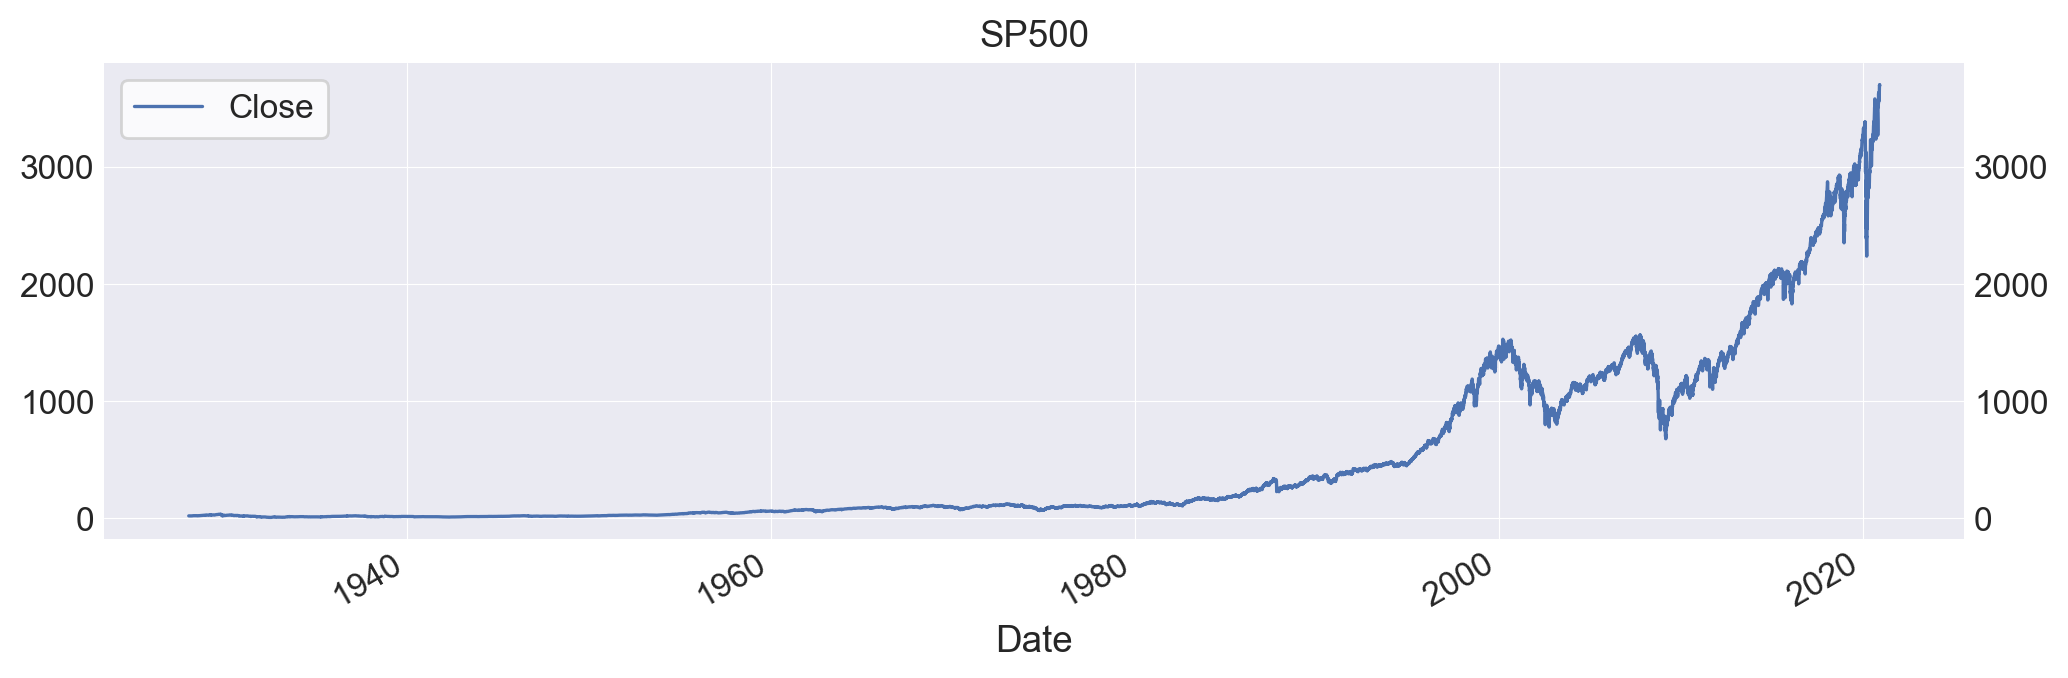

In [6]:
%run Functions.ipynb

#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data = data[['Open', 'Close']]

data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data[['Close', 'Market_daily_ret']]

data.info()
data.tail()
data['Close'].plot(title='SP500', legend=True)

## Walk-Forward Optimization

### Define values of Moving Averages and time periods for optimization

In [9]:
%run Functions.ipynb

fast_ma_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 500, 500]
slow_ma_list = [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

IS_start_years = pd.date_range(start='2000-01-01', end='2017-01-01', freq='1YS', closed=None)
IS_end_years = pd.date_range(start='2002-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start_years = pd.date_range(start='2003-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end_years = pd.date_range(start='2003-12-31', end='2020-12-31', freq='1Y', closed=None)

print(f'Number of combinations: {len(fast_ma_list)*len(slow_ma_list)}\n' 
      f'Length of memory (# of IS periods): {memory_len}')
print_periods(IS_start, IS_end, OOS_start, OOS_end)

num_combinations = len(fast_ma_list)*len(slow_ma_list)
num_is_years = round((IS_end[0]-IS_start[0]).days/365, 0)
num_oos_years = round((OOS_end[0]-OOS_start[0]).days/365, 0)
info_wf_str = (f'Running {num_combinations} backtests on \n'
               f'\t{len(IS_start)} IS rolling windows of {num_is_years} years\n'
               f'\t{len(OOS_start)} OOS rolling windows of {num_oos_years} years\n'
               f'->Total of {num_combinations*len(IS_start)+len(OOS_start)*2} backtests'
               f'\tMemory of {memory_len} IS periods\n'
              )
num_neighbors_matrix = get_num_neighbors_ma_crossover(fast_ma_list, slow_ma_list)

Number of combinations: 289
Length of memory (# of IS periods): 5
Number of periods: 18 : 18     18 : 18
	In SAMPLE		OOS
2000-01-01 : 2002-12-31 	 2003-01-01 : 2003-12-31
2001-01-01 : 2003-12-31 	 2004-01-01 : 2004-12-31
2002-01-01 : 2004-12-31 	 2005-01-01 : 2005-12-31
... ... ... ... ... ... 	 ... ... ... ... ... ...
2016-01-01 : 2018-12-31 	 2019-01-01 : 2019-12-31
2017-01-01 : 2019-12-31 	 2020-01-01 : 2020-12-31


### Optimization

In [10]:
%run Functions.ipynb
df_walk_forward = data[IS_start_years[0]:OOS_end_years[-1]].copy()
df_walk_forward = df_walk_forward.loc[:'2020-05-02']

# Copy data and create necessary columns 
cols = ['Strat_daily_ret', 'Strat_position_EOD', 'Long_only', 'Costs', 'Market_cum_ret']

df_walk_forward = df_walk_forward.reindex(columns = df_walk_forward.columns.tolist() + cols)

last_position = 0 # We suppose that we start not being invested. 1:long, -1:short


indiv_ir_list = []
robust_ir_list = []
market_ir_list = []

best_combinations_list = []
market_max_dd_list = []
strat_max_dd_list = []
market_pln_list = []
strat_pln_list = []
market_ir_list = []
strat_ir_list = []
market_max_dd_list = []


num_loop=0
for IS_start, IS_end, OOS_start, OOS_end in zip(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years):
    #if num_loop == 2: break
    #num_loop += 1
    
    results_ir = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    results_pnl = np.zeros((len(fast_ma_list),len(slow_ma_list)))

    is_period = df_walk_forward.loc[IS_start:IS_end].copy()
    oos_period = df_walk_forward.loc[OOS_start:OOS_end].copy()
    
    ############################################ IN SAMPLE  ############################################
    results_pnl, results_ir, market_ir = run_all_combinations(is_period, fast_ma_list, slow_ma_list, last_position)
    title = "Individual SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    #show_heatmap(results_ir, market_ir, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    indiv_ir_list.append(results_ir)
    market_ir_list.append(market_ir)

    # Get index of maximum SR for the In-Sample period
    fast_index, slow_index, robust_results_ir = get_best_combination(market_ir, results_ir, num_neighbors_matrix, allow_long_only=False)
    title = "Robust SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    #show_heatmap(robust_results_ir, market_ir, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    robust_ir_list.append(robust_results_ir)
    
    print("Best In-sample performance: ")
    print_backtest_stats_ma(is_period, fast_ma_list[fast_index], slow_ma_list[slow_index],
                            ret_strat=results_pnl[fast_index, slow_index], ir_strat=results_ir[fast_index, slow_index],  
                           market_ir=market_ir)
    
    ############################################ OUT OF SAMPLE  ############################################
    print("OOS performance:")
    _, last_position, market_pnl, market_ir = backtest_strat_ma(oos_period, fast_ma=1, slow_ma=1, previous_position=0) # Market- always long
    _, last_position, strat_pnl, strat_ir = backtest_strat_ma(oos_period, fast_ma_list[fast_index], slow_ma_list[slow_index], previous_position=last_position)
    print_backtest_stats_ma(oos_period, fast_ma_list[fast_index], slow_ma_list[slow_index], strat_pnl, strat_ir, market_ir)  
    
    ############################################ Save metrics  ############################################
    best_combinations_list.append([fast_ma_list[fast_index], slow_ma_list[slow_index]])
    market_max_dd_list.append(oos_period['Market_daily_ret'].max_drawdown())
    strat_max_dd_list.append(oos_period['Strat_daily_ret'].max_drawdown())
    market_pln_list.append(market_pnl)
    market_ir_list.append(market_ir)
    strat_pln_list.append(strat_pnl)
    strat_ir_list.append(strat_ir)
    
    # Save come columns from OOS
    df_walk_forward.loc[OOS_start:OOS_end, cols] = oos_period[cols]
    print()
    
print("End of optimization")

NameError: name 'IS_start_years' is not defined

### Check chosen MA combinations

### Plot OOS of Strategy vs Benchmark

,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Fast_ma,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,25,1,1,1,1,1,1,1,1,65,1,65,65,1,35,30,0,1,0,50,0,35,65,65,1,0,0,50,50,55,50,50,0,0,30,35,5,45,45,50,0,55,0,20,25,1
Slow_ma,40,5,5,140,10,20,20,5,5,10,10,10,10,5,5,5,5,5,5,5,5,5,260,5,100,5,5,5,5,5,5,140,220,180,180,20,40,40,0,260,0,120,0,80,220,200,5,0,0,260,260,220,240,240,0,0,240,220,100,120,120,140,0,120,0,60,40,10
Long_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0


0    59
1     9
Name: Long_only, dtype: int64

1     34
0      9
50     6
65     5
35     3
55     2
45     2
30     2
25     2
20     1
5      1
3      1
Name: Fast_ma, dtype: int64

5      21
0       9
10      6
120     4
220     4
40      4
260     4
240     3
20      3
140     3
100     2
180     2
80      1
200     1
60      1
Name: Slow_ma, dtype: int64

<AxesSubplot:title={'center':'Best MA combination chosen'}>

<AxesSubplot:>

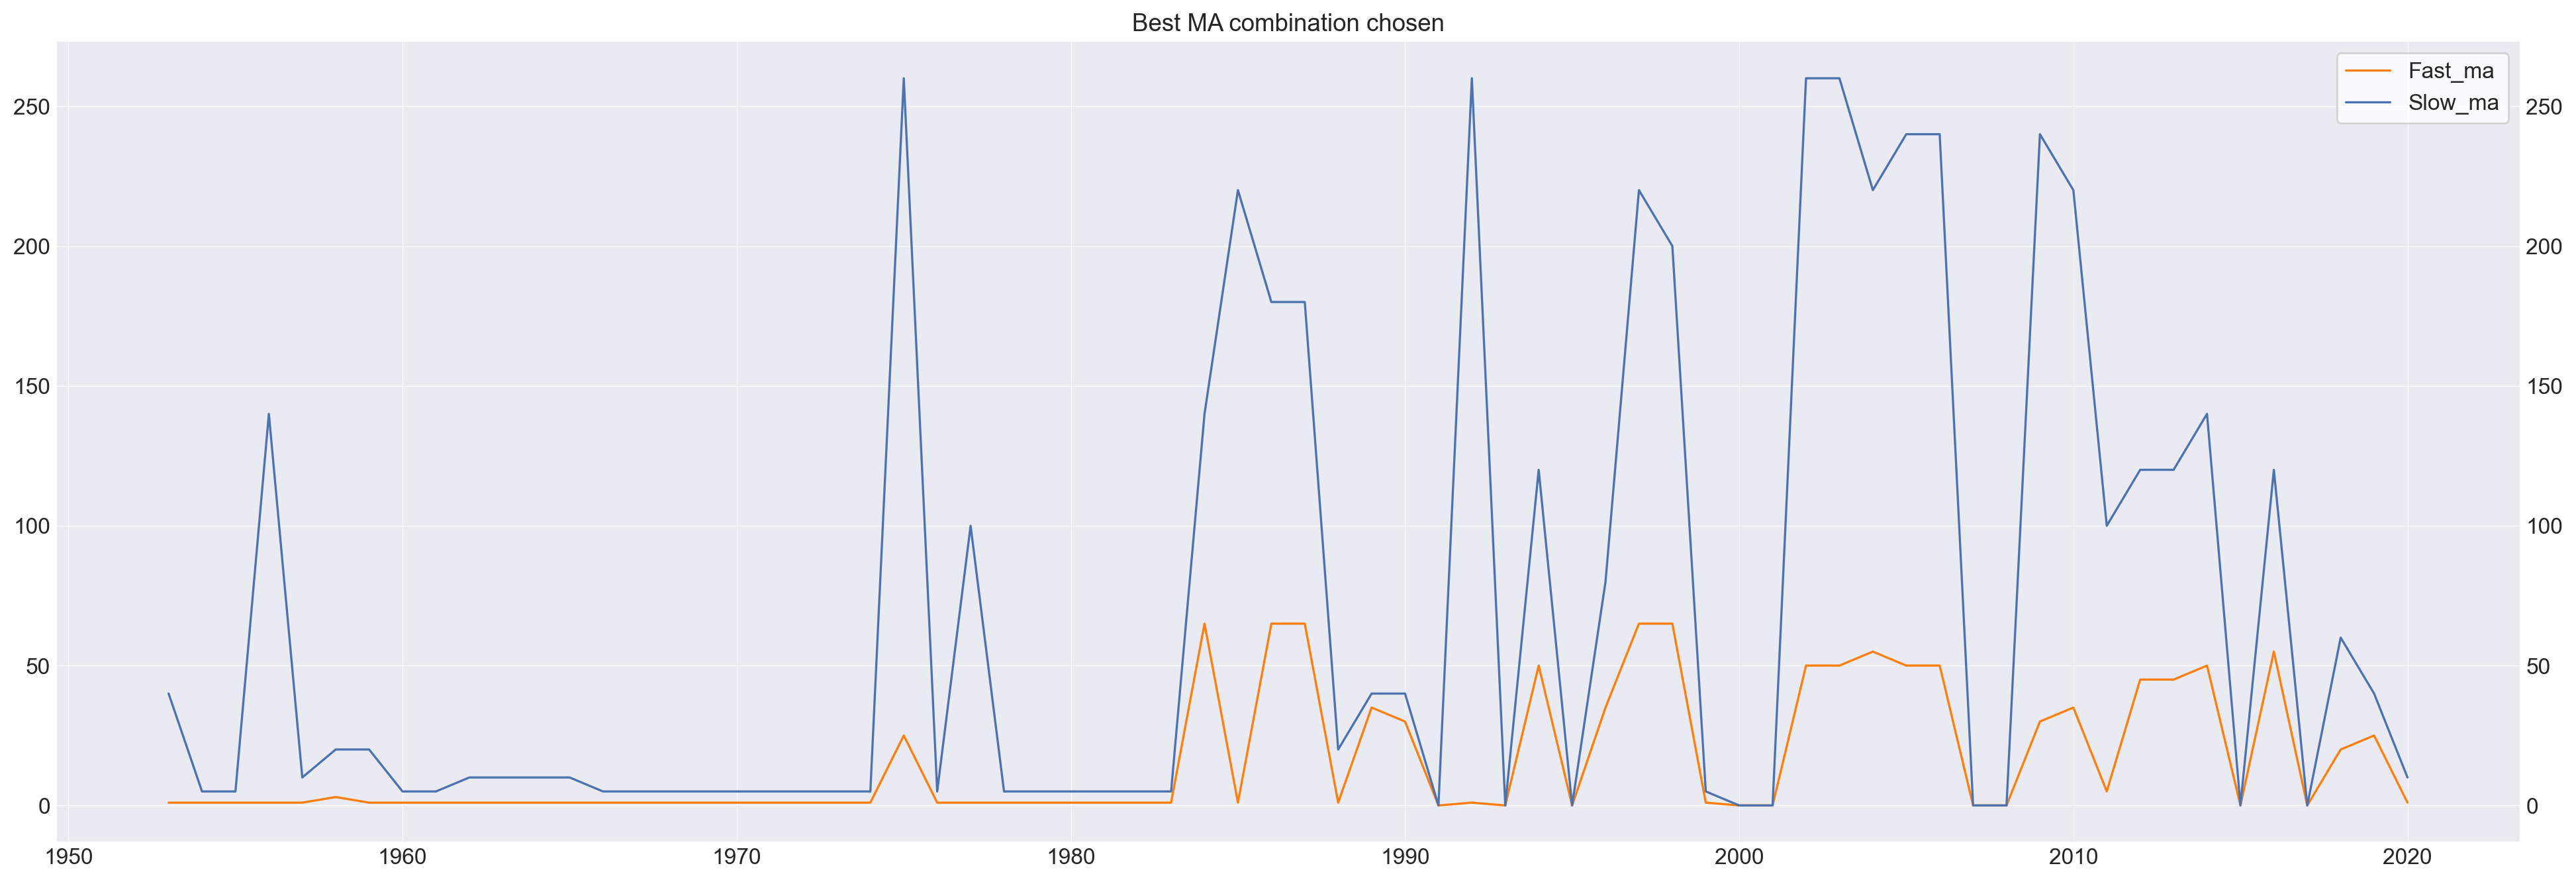

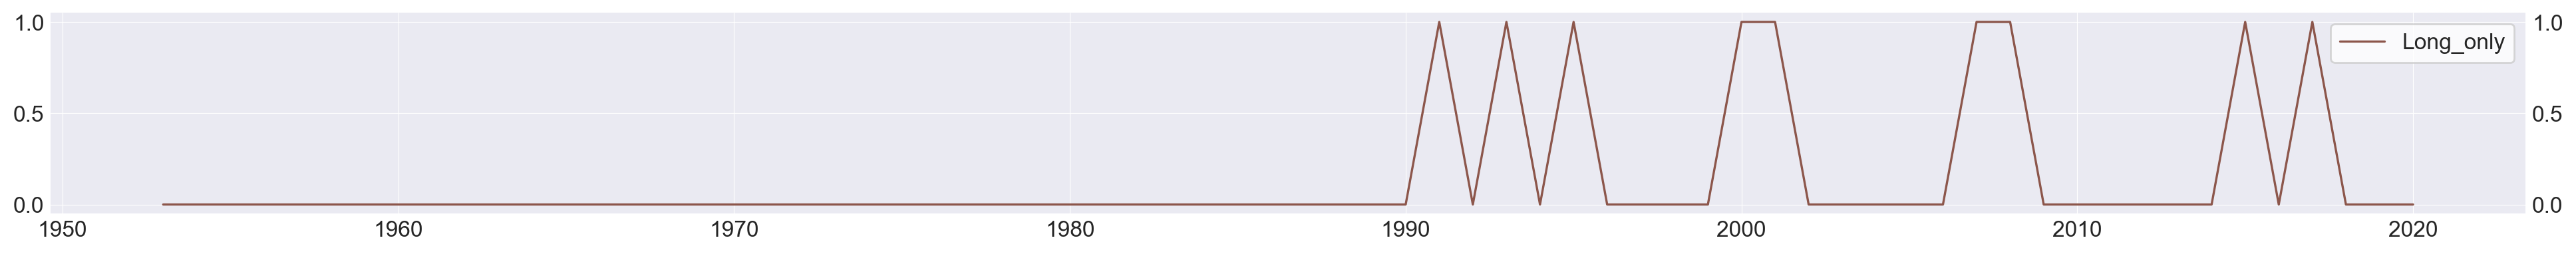

In [12]:
bests = pd.DataFrame(best_combinations_list, columns=['Fast_ma', 'Slow_ma'], index=OOS_start_years.year)
bests[['Fast_ma', 'Slow_ma']] = bests[['Fast_ma', 'Slow_ma']].where(bests['Fast_ma'] != bests['Slow_ma'], other=0)
bests['Long_only'] = np.where(bests['Fast_ma'] == bests['Slow_ma'], 1, 0)
bests.T
bests['Long_only'].value_counts()
bests['Fast_ma'].value_counts()
bests['Slow_ma'].value_counts()
bests[['Fast_ma', 'Slow_ma']].plot(figsize=(24,8), color=('tab:orange', 'b'), title="Best MA combination chosen")
bests[['Long_only']].plot(figsize=(24,2), color='tab:brown')
#bests.plot(secondary_y=['Long_only'], color=('tab:orange', 'b', 'tab:brown'))

,Close,Market_daily_ret,Strat_daily_ret,Strat_position_EOD,Costs,Long_only,Market_cum_ret,Strat_cum_ret
Date,,,,,,,,
1953-01-02,26.540001,-0.001129,-0.001240,1.0,0.002964,0.0,26.540001,26.537041
2020-05-01,2830.709961,-0.028059,-0.028167,NaN,0.968559,0.0,2830.709961,8682.661764


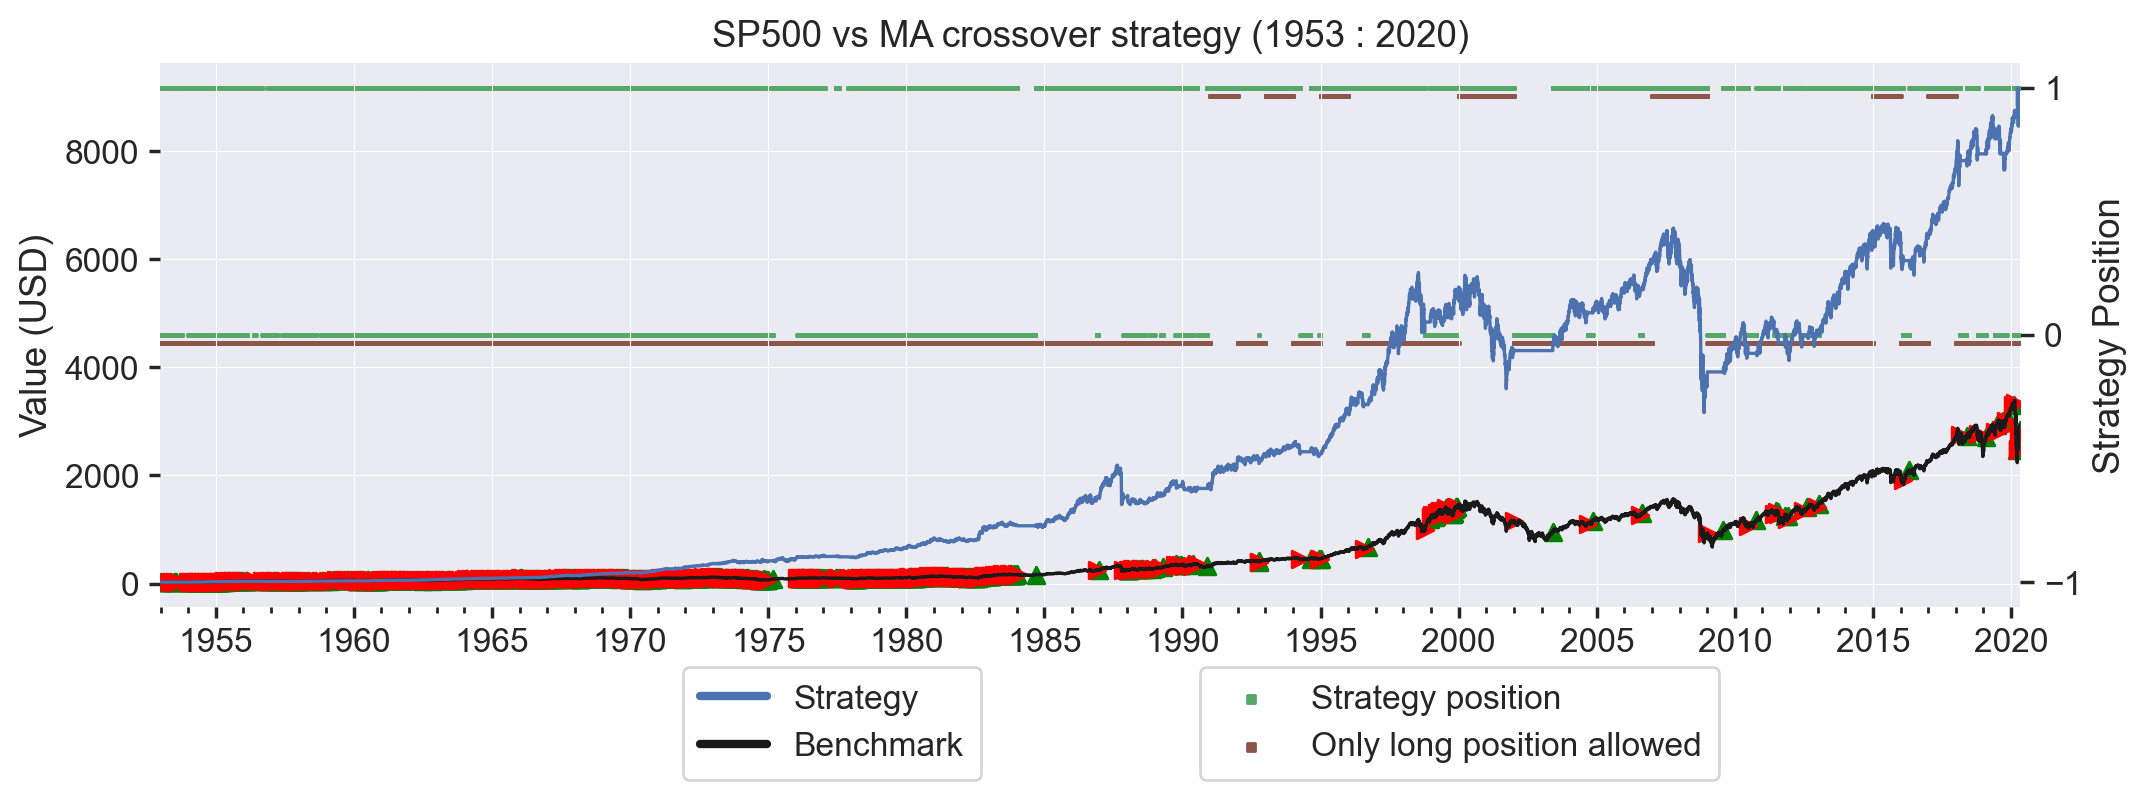

In [13]:
ini_mon = df_walk_forward[str(OOS_start_years[0].year-1)].iloc[-1]['Close']
#ini_mon = 100
results_df = prepare_oos_df(df_walk_forward.loc[OOS_start_years[0]:OOS_end_years[-1]].copy(), ini_equity=ini_mon)
results_df.iloc[[0,-1]]
show_oos_plot(results_df, legend=True, with_signals=True)
#plt.show()
#results_df['Costs'].cumsum().plot();

,Close,Market_daily_ret,Strat_daily_ret,Strat_position_EOD,Costs,Long_only,Market_cum_ret,Strat_cum_ret
Date,,,,,,,,
2000-01-03,1455.219971,-0.009549,-0.009660,1.0,0.163878,1.0,1455.219971,1455.057658
2020-05-01,2830.709961,-0.028059,-0.028167,NaN,0.259332,0.0,2830.709961,2324.784431


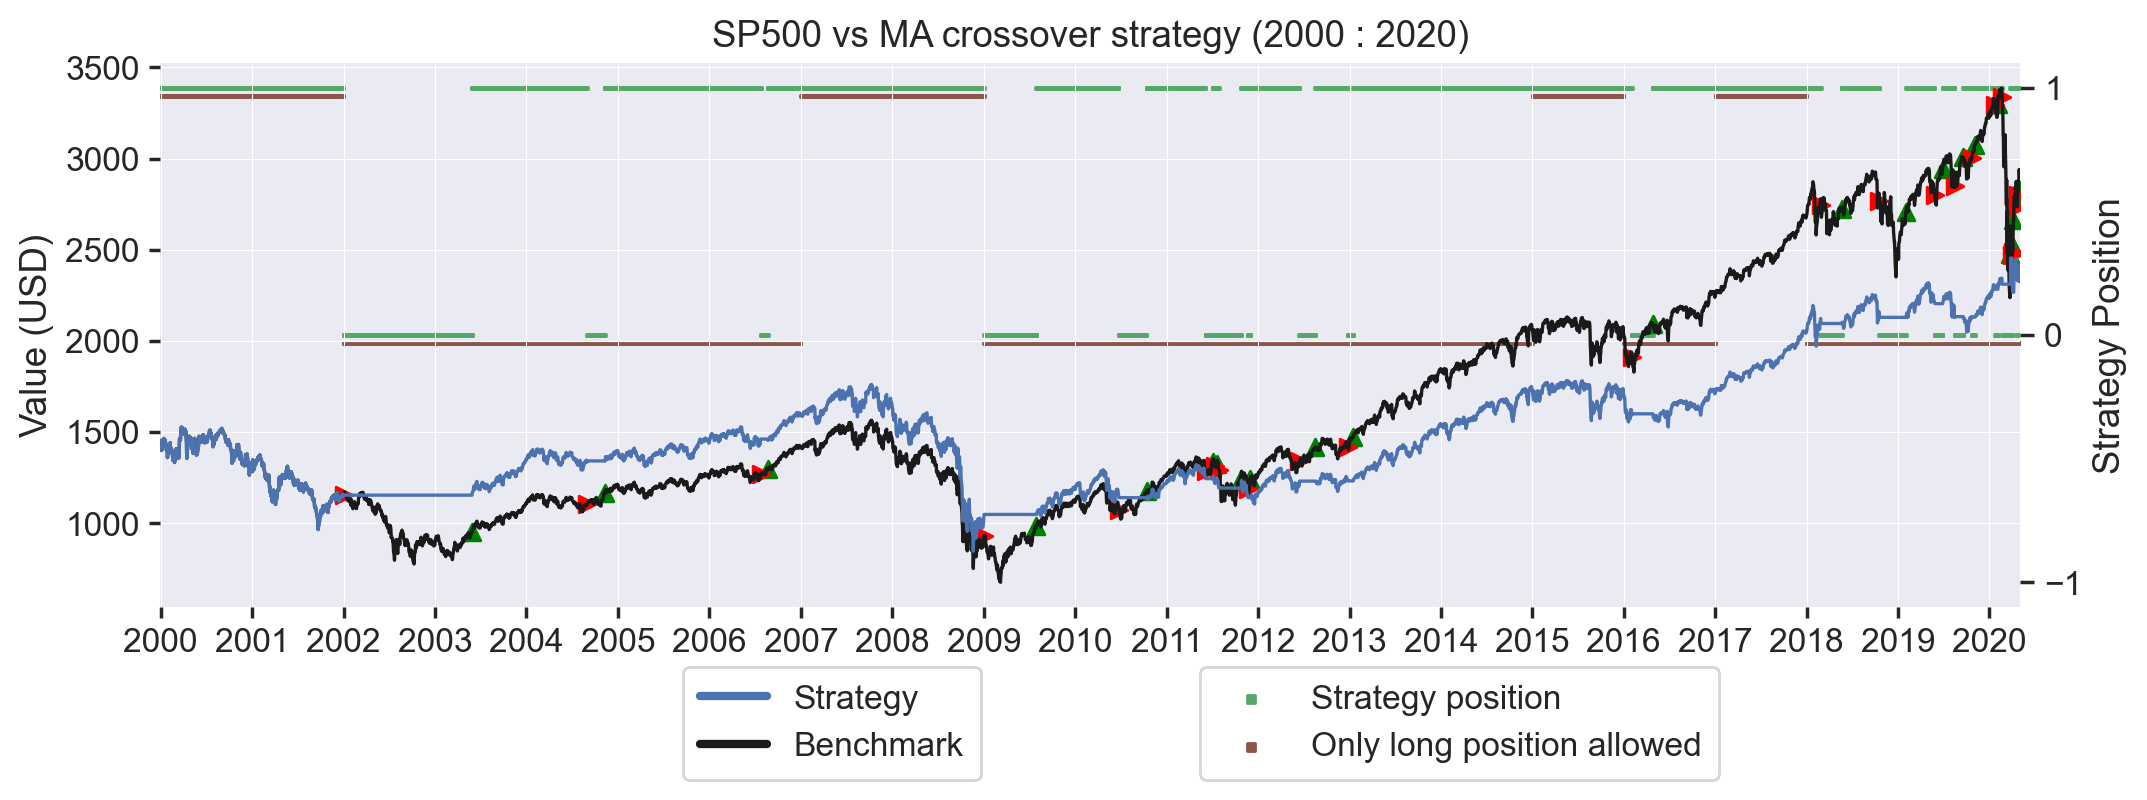

In [15]:
## After 2000:
ini_mon = df_walk_forward[str('1999')].iloc[-1]['Close']
#ini_mon = 100
results_df = prepare_oos_df(df_walk_forward.loc['2000':].copy(), ini_equity=ini_mon)
results_df.iloc[[0,-1]]
show_oos_plot(results_df, legend=True, with_signals=True)

### Save metrics from the optimization

In [ ]:
#results_df.to_csv('data/Strategy returns.csv')

In [22]:
metrics = ['PNL', 'IR', 'MAX_DD']
index = pd.MultiIndex.from_product([['SP500', 'Strategy']], names=['Asset'])
columns = pd.MultiIndex.from_product([[], metrics], names=['Year', 'Metric'])

metrics_df = pd.DataFrame([], index=index, columns=columns)

for i, year in enumerate(OOS_start_years.year):
    year_sp_pln = market_pln_list[i]
    year_oos_pln = strat_pln_list[i]
    year_sp_ir = market_ir_list[i]
    year_oos_ir = strat_ir_list[i]
    year_sp_dd = market_max_dd_list[i]
    year_oos_dd = strat_max_dd_list[i]
    
    year_data = [[year_sp_pln, year_sp_ir, year_sp_dd], [year_oos_pln, year_oos_ir, year_oos_dd]]
    
    metrics_df = add_data(metrics_df, year_data, year)

metrics_df

Year           1953                         1954                         1955                         1956                        1957                         1958                         1959                         1960                         1961                         1962                         1963                         1964                         1965                         1966                         1967                         1968                         1969                         1970                         1971                         1972                         1973                         1974                         1975                         1976                        1977                         1978                         1979                         1980                        1981                         1982                         1983                         1984                         1985                         1986                   \
Metric          PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD        PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD        PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD        PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD         PNL     IR    MAX_DD   
Asset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
SP500     93.365572  1.334 -0.148162  145.005994 -0.718 -0.044217  126.389459  0.686 -0.105851  102.605086  3.953 -0.105963  85.677186  1.531 -0.206595  138.044108  1.518 -0.043570  108.464627  1.513 -0.091748   97.017064  0.208 -0.135618  123.114820  1.665 -0.062318   88.180234 -1.191 -0.264445  118.877386  0.257 -0.065387  112.957279  3.590 -0.035466  109.049783  0.556 -0.096045   86.899320  0.861 -0.221773  120.078724  0.779 -0.066093  107.648404 -0.292 -0.093052   88.628662  1.290 -0.159759  100.086602  2.071 -0.258613  110.774398  0.867 -0.139448  115.620374 -0.757 -0.051355   82.625260  0.136 -0.233533   70.274063  2.019 -0.375952  131.534344  0.694 -0.141408  119.135170  2.308 -0.083650  88.488174  0.502 -0.152243  101.050770  1.248 -0.135527  112.296288  1.802 -0.102453  125.759541 -1.190 -0.170719  90.259531  0.267 -0.183536  114.748518  2.190 -0.165553  117.257962  0.465 -0.069068  101.389292  0.877 -0.126772  126.319317  0.403 -0.076616  114.607624 -1.212 -0.094236   
Strategy  96.100504 -0.6

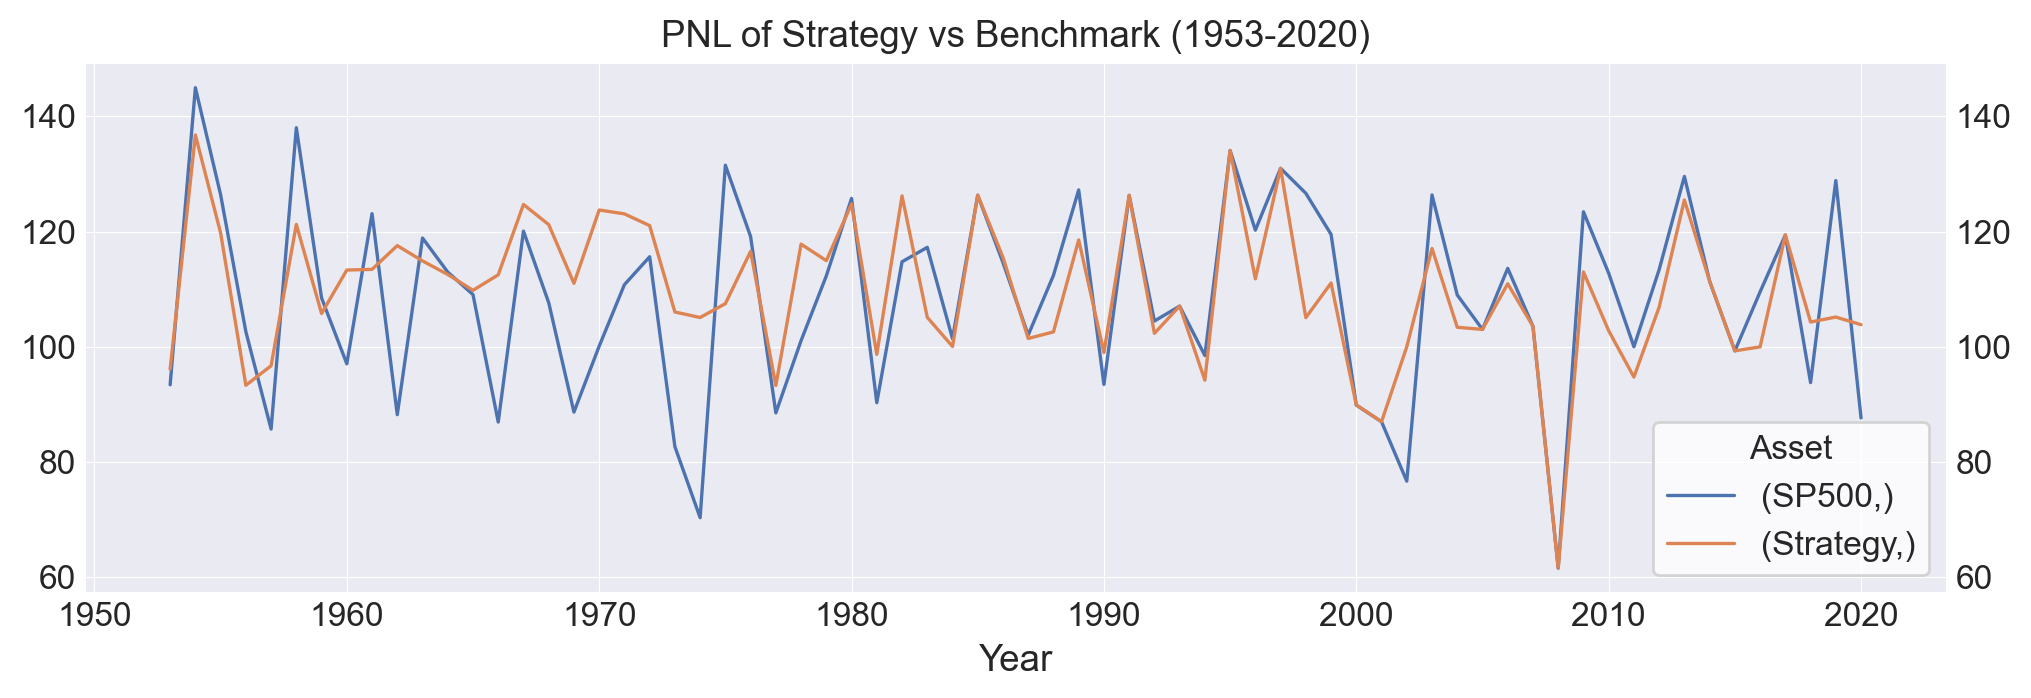

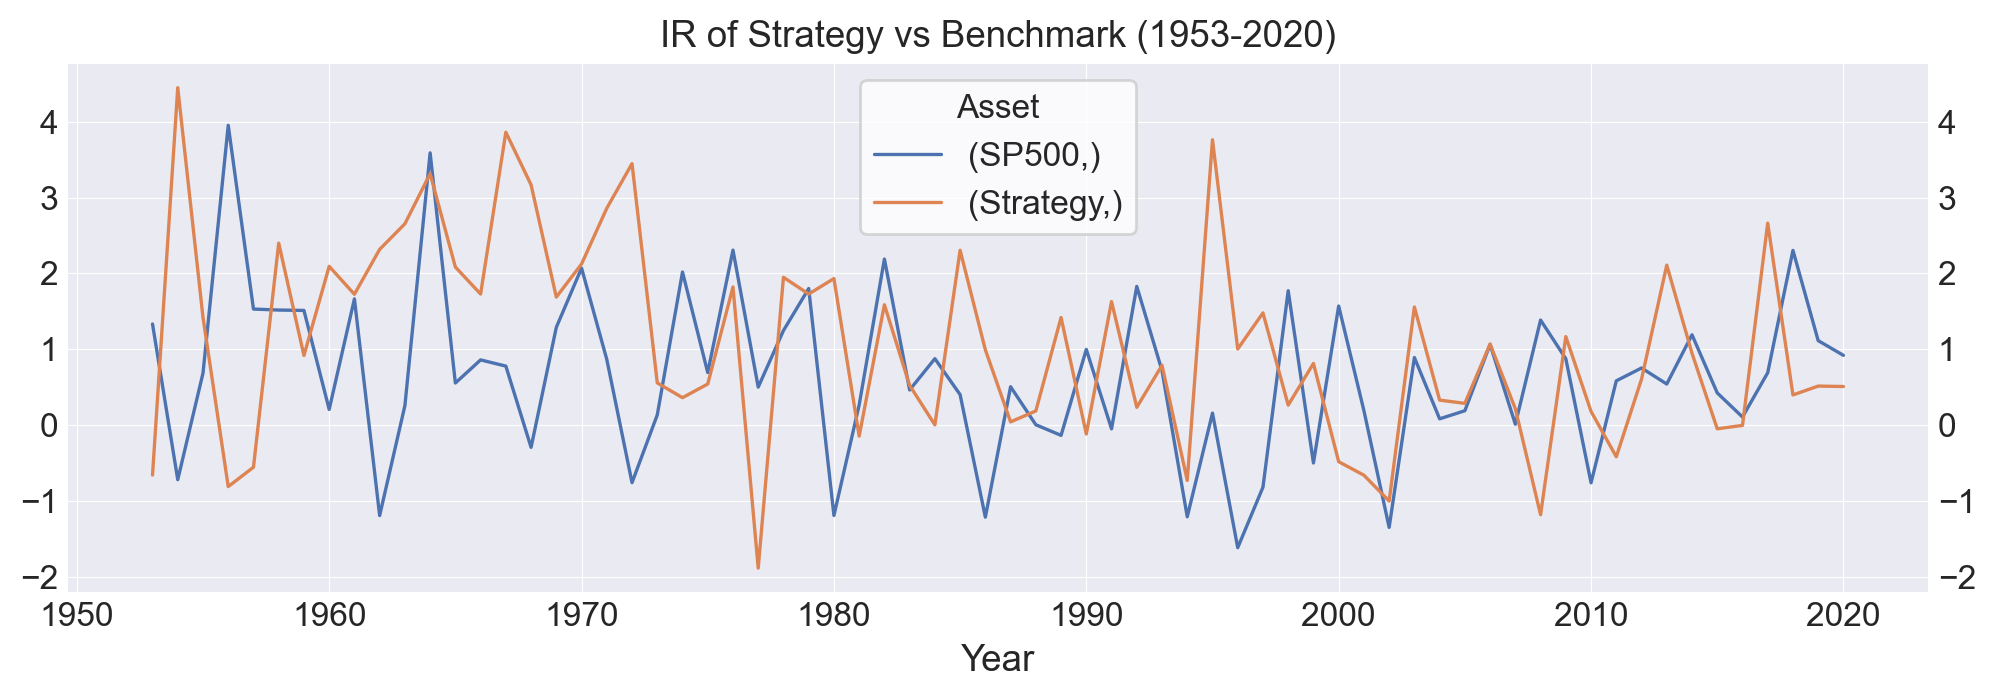

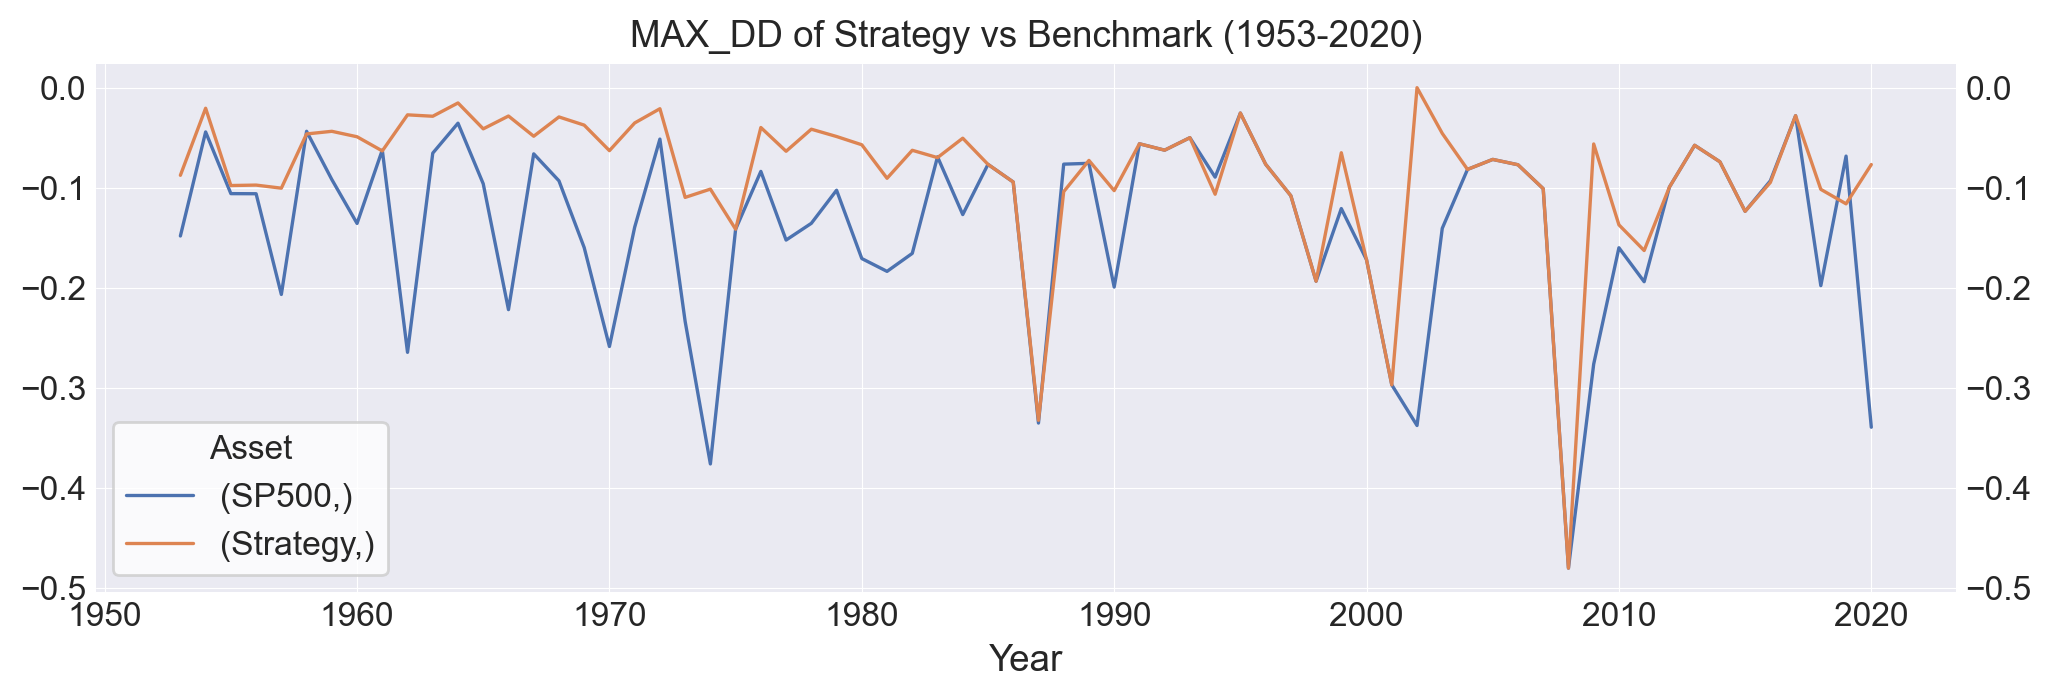

In [23]:
metrics_df.xs('PNL', axis=1, level=1)
metrics_df.xs('PNL', axis=1, level=1).T.plot(title="PNL of Strategy vs Benchmark (1953-2020)");
metrics_df.xs('IR', axis=1, level=1).T.plot(title="IR of Strategy vs Benchmark (1953-2020)");
metrics_df.xs('MAX_DD', axis=1, level=1).T.plot(title="MAX_DD of Strategy vs Benchmark (1953-2020)");

In [ ]:
#metrics_df.xs('Strategy', axis=0).round(3).to_clipboard(sep=',')
#metrics_df.xs('Strategy', axis=0).T.sort_index().round(3).to_clipboard(sep=',')
#metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index().round(3).to_clipboard(sep=',')

#metrics_df.round(3).to_csv("metrics.csv", sep=';')

In [ ]:
#by column: metrics_df.xs('PNL', axis=1, level='Metric')
#metrics_df.xs('PNL', axis=1, level=1) 
#metrics_df.xs('SP500', axis=0) #by index
#metrics_df.loc['SP500', (2013, 'PNL')]
#met = metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index()
#met

## Analysis of OOS performance

### HTML Reports 

In [ ]:
%run Functions.ipynb
html_df = results_df.copy()
html_df.iloc[[0,-1]]

#### Strategy

#### Benchmark

### Annualized returns

###  Overall performance (PNL and SR)

In [26]:
n_years = OOS_start_years[-1].year - OOS_start_years[0].year + 1

# overall_ret_sp = (results_df.at[results_df.index.max(), 'Close'] - results_df.at[results_df.index.min(), 'Close']) / results_df.at[results_df.index.min(), 'Close']
# overall_ret_sp
overall_ret_sp = (results_df.at[results_df.index.max(), 'Market_cum_ret'] - results_df.at[results_df.index.min(), 'Market_cum_ret']) / results_df.at[results_df.index.min(), 'Market_cum_ret']
overall_ret_strat = (results_df.at[results_df.index.max(), 'Strat_cum_ret'] - results_df.at[results_df.index.min(), 'Strat_cum_ret']) / results_df.at[results_df.index.min(), 'Strat_cum_ret']
annualized_ret_sp = (1 + overall_ret_sp)**(1/n_years) - 1
annualized_ret_strat = (1 + overall_ret_strat)**(1/n_years) - 1

print("Overall OOS performace:")
print("\t\tMarket\tStrategy\nOverall ret:\t{:.2f}\t{:.2f}\nAnnualized:\t{:.3f} %\t{:.3f} %".format(overall_ret_sp, overall_ret_strat, 
                                           annualized_ret_sp*100, annualized_ret_strat*100))
print("Average PNL:\t{:.2f}\t{:.2f}".format(np.mean(market_pln_list), np.mean(strat_pln_list)))
print("SR:\t\t{:.2f}\t{:.2f}".format(results_df['Market_daily_ret'].sharpe(), results_df['Strat_daily_ret'].sharpe()))


Overall OOS performace:
		Market	Strategy
Overall ret:	0.95	0.60
Annualized:	0.983 %	0.691 %
Average PNL:	108.48	109.60
SR:		0.26	0.22
